# Iterative Model Dev 1<br/>*Establish a Baseline model*

Jupyter Notebook referenced from my website:
[Software Nirvana: Iterative Dev 1](https://sdiehl28.netlify.com/2018/02/iterative-model-dev-1/)

### Machine Learning Example
Make a prediction for Survived / Not-Survived using the titanic dataset from Kaggle.  This is a supervised classification problem.

Several notebooks will be created after this one.  Each iteratively improving:
* the model's accuracy
* the workflow used to create the model

<a name="outline"></a>
### Outline
1. [Acquire and Read Data](#readdata)
2. [Identify Target Variable](#target)
3. [Tentative Assumptions For 1st Iteration](#assumptions)
4. [Model Building & Evaluation](#model)
6. [Summary](#summary)

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Software Versions
If your results are different from these notebooks, it may be that you need to upgrade the version of the software you are using.  On Linux, using the Anaconda distribution, this is done by:
```
source activate <env>
conda update conda
conda update --all
```

In [2]:
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)

python:      3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
numpy:       1.14.1
pandas:      0.22.0
matplotlib:  2.2.0
seaborn:     0.8.1
sklearn:     0.19.1


<a name="readdata"></a>
### Acquire the Data
[Back to Outline](#outline)

Download "train.csv" from: https://www.kaggle.com/c/titanic/data and place it in a data subdirectory.

This link also has the data dictionary (sometimes called the codebook).

### Read in Data

In [3]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a name="target"></a>
### Target Variable: Survived
[Back to Outline](#outline)

Create two variables from the data we read in preparation for creating a predictive model.  

X: A Pandas DataFrame that represents the features (aka attributes)  
y: A Pandas Series that represents the target (aka response)  

In [4]:
# X: drop target variable
# y: keep only the target
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)

X Shape:  (891, 11)
y Shape:  (891,)


In [5]:
# ndim, as in numpy, reports the number of dimensions (e.g. 1D, 2D)
print('X dimensions: ',X.ndim)
print('y dimensions: ',y.ndim)

X dimensions:  2
y dimensions:  1


In [6]:
# aside for later
# y is a 1D object
# sometimes we need its 2D equivalent: a 2D object having 1 column
# using .values picks out the values as a numpy array
# using reshape(-1,1) converts it to a 2D object having 1 column
y_2D = y.values.reshape(-1,1)
print('y_2D type: ', type(y_2D))
print('y_2D shape: ', y_2D.shape)
print('y_2D dimensions: ', y_2D.ndim)
print('contents match: ',(y.values == y_2D.flatten()).all())

y_2D type:  <class 'numpy.ndarray'>
y_2D shape:  (891, 1)
y_2D dimensions:  2
contents match:  True


<a name="assumptions"></a>
### First Iteration Assumptions
[Back to Outline](#outline)  

In order to quickly get something up and running, let's arbitrarily decide upon the following:
* use LogisticRegression (as is common for classification problems)
* drop ID field
* drop all non-numeric features
* drop any column having a null value
* model evaluation metric: accuracy (auc is another good choice)

In [7]:
X.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
# Remove all non-numeric fields and PassengerId
drop_cols = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
X = X.drop(drop_cols, axis=1)

In [9]:
# Find the percentage of missing values per column
nrows, ncols = X.shape
X.isnull().sum() / nrows

Pclass    0.000000
Age       0.198653
SibSp     0.000000
Parch     0.000000
Fare      0.000000
dtype: float64

In [10]:
# Remove Age as it has null values (for the 1st iteration only)
drop_cols = ['Age']
X = X.drop(drop_cols, axis=1)
X.dtypes

Pclass      int64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

### Exploratory Data Analysis
Examining the codebook (aka data dictionary) at: https://www.kaggle.com/c/titanic/data
shows that Pclass is an ordered categorical variable that happens to be encoded as an integer.  Let's take a quick look at how survival is related to passenger class.

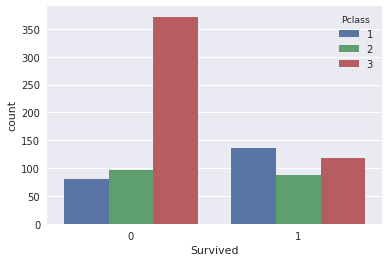

In [11]:
sns.countplot(x='Survived', hue='Pclass', data=all_data)

0 means did not survive and 1 means survived.

The above shows that 1st class passengers had a higher survival rate than 2nd class passengers who had a higher survival rate the 3rd class passengers.

Passenger class is not a continuous variable.  The distance between 1st class and 2nd class is not the same as the distance between 2nd class and 3rd class; in fact, the distance is not defined.  Nevertheless for predictive modeling purposes, given that the ordinal encoding matches its association with the target variable, leaving it encoded as an integer is a good approach.

For now, let's keep passenger class encoded as an integer.

<a name="model"></a>
### Model Building & Evaluation
[Back to Outline](#outline)

A train/test split will be used to demonstrate how to build and evaluate a model.

The random_state will be set so that these results are repeatable.

Cross validation will be used to get a better estimate of the model's accuracy.

In [12]:
# create the train/test split
# for a single train/test split, with uneven target class distributions, statify=y is good
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.30, stratify=y, random_state=10)

In [13]:
# Build Model on Train Data
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
# Use model fitted on train data to make predictions on test data
predictions = base_model.predict(X_test)

In [15]:
# Compute accuarcy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.6305970149253731

In [16]:
# Compute accuracy manually to be sure we understand accuracy_score()
# The following computes the mean number of True values, which is the precentage of True values
print((predictions == y_test).mean())

0.6305970149253731


Accuracy is sometimes referred to as:
TP + TN / (TP + FP + TN + FN)

Where "Positive" in this example is "Survived"
<pre>
TP = True  Positive  
FP = False Positive 
TN = True Negative  
FN = False Negative
</pre>

In [17]:
# For instructional purposes, let's derive the confusion matrix ourselves
# Recall that y_test is the actual data from the test set
TP = ((predictions == 1) & (y_test == 1)).sum()
FP = ((predictions == 1) & (y_test == 0)).sum()
FN = ((predictions == 0) & (y_test == 1)).sum()
TN = ((predictions == 0) & (y_test == 0)).sum()
print(TP, FP,"\n",FN, TN)

43 39 
 60 126


In [18]:
# Have sklearn compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = confusion.flatten() # see confusion matrix documentation
print(tp, fp, "\n", fn, tn)

43 39 
 60 126


For our single train/test split, we got an accuracy estimate of 63.1%.

### Cross Validation
Each time we randomly chose a different train and test subset of our data, we will get a different estimate of the model's accuracy.  If we do this only once, we risk having an unrepresentative train/test split.

A better approach is to take several train/test splits and compute the accuracy of each.  This is what Cross Validation does.

Good overview of cross validation and overfiting in Python: [Train/Test Split and Cross Validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)

Good overview of cross validation and overfitting in general:
* chapter 5.1 of [ISL](http://www-bcf.usc.edu/~gareth/ISL/)
* The first 3 videos for Chapter 5 [ISL Videos](http://www.dataschool.io/15-hours-of-expert-machine-learning-videos/)

In [19]:
from sklearn.model_selection import cross_val_score, KFold

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=5)
scores = cross_val_score(base_model, X, y, cv=crossvalidation, scoring='accuracy',
 n_jobs=1)
print(np.round(scores, 3))

[0.726 0.708 0.635 0.674 0.68 ]


### Examine What Scikit Learn Did Behind the Scenes
The [cross_val_score()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) helper function does a lot.  Let's do exactly the same thing by hand to verify we understand what it does.

A [crossvalidation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object is returned from the call to KFold.  [crossvalidation.split(X)](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split) is an iterator which returns 2 numpy arrays, one for the train subset and one for the test subset.

Compute the accuracy score using the iterator and compare with cross_val_score().

In [20]:
n_splits = 5
my_scores = np.zeros(n_splits)
i = 0
lr_model = LogisticRegression()
for train_idx, test_idx in crossvalidation.split(X):
    # train subset
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    # test subset
    X_test = X.iloc[test_idx, :]
    y_test = y[test_idx]
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    my_scores[i] = accuracy_score(y_test, predictions)
    i += 1
print(np.round(my_scores, 3))
print('Scores match: ',(scores == my_scores).all())

[0.726 0.708 0.635 0.674 0.68 ]
Scores match:  True


In [21]:
# let's use the average of the CV score as the metric of base model performance
print('average: {:5.3f}'.format(np.mean(scores)))

average: 0.685


In [22]:
# Compare with Simplest Possible Model Sometimes called the Null Model
# Null Model Predicts predominant class every time
y_test.value_counts()

0    112
1     66
Name: Survived, dtype: int64

In [23]:
# Null Model Accuracy
null_accuracy = 165 / (165 + 103)
print('Null Model Accuracy: {:5.3f}'.format(null_accuracy))

Null Model Accuracy: 0.616


68.5% is better than the null model accuracy 61.6%.  This is likely to be statistically significant.  A hypothesis test could be performed to see if it is, but that will not be done here.

Here we will simply say that our simple Logistic Regression Model appears to be off to a good start.

<a name="summary"></a>
### Summary
[Back to Outline](#outline)

In this first iteration we:
* discussed how Scikit Learn computes accuracy, the confusion matrix, and cross validation scores
* created a simple model to use as our baseline
* established a baseline accuracy of 68.5%
* showed that this accuracy is better than the null model accuracy of 61.6%